# Evaluation / results

In [1]:
import pandas as pd
import numpy as np

### Performace: nDCG, Recall and Precision

In [2]:
import math
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) #topK
    idealOrder = ground_truth
    idealDCG = 0.0
    
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))


### Diversity: ILD, and Entropy

In [3]:
# intra list distance
def ILD(_recList):
    
    
    _recList_if_ids = [InnerID_to_iiMatrixID[Inner_ID] for Inner_ID in _recList]
#     _recList_if_ids = list(map(int(InnerID_to_iiMatrixID), _recList))   
    
    
    totalDisSimilarityPerUser = 0
    topK =  len(_recList)
    
    c = []
    for item_i in _recList_if_ids:            
        for item_j in _recList_if_ids:
            if (item_i != item_j):
                # this vector (i) and that vector (j)
                totalDisSimilarityPerUser += (1.0 - itemItemSimilarityByFeature[item_i, item_j])
    
    diversityPerUser = (totalDisSimilarityPerUser * 2.0) / (topK * (topK - 1.0))
    return (diversityPerUser)


def ENTROPY_(_recList):
    _recList_ids = list(map(int, _recList))
    feature_count_vector = item_features_df[item_features_df.index.isin(_recList_ids)].sum(axis=0)
    
    # turn it back to a list of labels so we can pass it to entropy_()
    _recList_item_features = [i for i in feature_count_vector[feature_count_vector != 0].index for j in range(feature_count_vector[i])]
    # send the labels to the entropy_() to calculate the netropy over all the labels combined.
    return entropy_(_recList_item_features)

    
def entropy_(labels, base=None):
    from math import log, e
    """ Computes entropy of label distribution. """

    n_labels = len(labels)
    if n_labels <= 1:
        return 0

    value, counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0
    
    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)
    return ent

### Fairness: Statistical Parity and Calibration

### ----------------------------------- data input ------------------------------------------

### This should be changes based on the dataset and what the system/we want.

In [5]:
genres = ['Animation',
 'Comedy',
 'Family',
 'Adventure',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'History',
 'Science Fiction',
 'Mystery',
 'War',
 'Foreign',
 'Music',
 'Documentary',
 'Western',
 'TV Movie',
 'Adult']

In [6]:
countries = pd.read_csv('./data/countries.csv', header=None)
countries = countries[0].tolist()
# countries

In [7]:
pro_genres = ['Horror', 'Music', 'History', 'Mystery']
pro_countries = ['CA', 'DE', 'ES', 'HK']

In [30]:
unpro_genres = [c for c in genres if c not in pro_genres]
print(unpro_genres)
print(len(genres), len(pro_genres), len(unpro_genres))

['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Science Fiction', 'War', 'Foreign', 'Documentary', 'Western', 'TV Movie', 'Adult']
21 4 17


In [9]:
unpro_countries = [c for c in countries if c not in pro_countries]
# print(unpro_countries)
print(len(countries), len(pro_countries), len(unpro_countries))

161 4 157


In [35]:
pro = pro_countries + pro_genres
unpro = unpro_countries + unpro_genres

# protected group for activities?

In [11]:
def isProtected(itemId):
    if item_features_df.loc[item_features_df.index == itemId, pro].sum(axis=1).values[0] > 0:
        return True
    return False

### Loading feature matrix

In [12]:
item_features_df = pd.read_csv("./data/movie_iid_features_sampled.csv", sep=',',dtype=int)
item_features_df.set_index('Inner_ID', inplace=True)
item_features_df.head()

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
Inner_ID,,,,,,,,,,,,,,,,,,,,,
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Turning inner_ID to innerid for this item item similarity matrix

In [13]:
InnerID_to_iiMatrixID = {}
iiMatrixID_to_InnerID = {}

for i in range(item_features_df.shape[0]):
    iiMatrixID_to_InnerID[i] = item_features_df.index[i]
    InnerID_to_iiMatrixID[item_features_df.index[i]] = i

print(InnerID_to_iiMatrixID[1606])

5786


In [14]:
item_features_df.index

Int64Index([ 2673, 12048,  5728,  4439, 12943,  3170, 12148, 11476, 11029,
             6572,
            ...
             7531,  7254,  4502,  3839, 13301,  1738,  6107,  1919,  2619,
             5749],
           dtype='int64', name='Inner_ID', length=14491)

### Calcualting the feature based item-item similarity

In [15]:
# ---------------------------------------------------------------------------------------
# calcualte the item-item similarity matrix by its features
from sklearn.metrics.pairwise import cosine_similarity
itemItemSimilarityByFeature = cosine_similarity(item_features_df.values)
itemItemSimilarityByFeature.shape

(14491, 14491)

In [16]:
itemItemSimilarityByFeature[InnerID_to_iiMatrixID[14552],0]

0.4216370213557839

# NOTE: not looking at high rating items (ratings >=4)

In [17]:
def evaluation(groundTruth, recs):
    import timeit
    start = timeit.default_timer()

    p = []
    r = []
    n = []
    ild = []
    ent = []


    for u in np.unique(groundTruth['userid'].tolist()):
        if len(groundTruth[groundTruth['userid'] == u]) > 0:

            test_items = groundTruth.loc[(groundTruth['userid'] == 0) & (groundTruth['rating'] >= 4), 'itemid'].tolist()

            if len(test_items) > 0:
                # top items
                top_items = recs.loc[recs['userid'] == u, 'itemid'].tolist()

                recall = Recall(test_items, top_items)
                precision = Precision(test_items, top_items)
                ndcg = nDCG_Time(test_items, top_items)

                # only top_items or recommendation list is needed for diversity
                diversity_ild = ILD(top_items)
                diversity_entropy = ENTROPY_(top_items)


                r.append(recall)
                p.append(precision)
                n.append(ndcg)
                ild.append(diversity_ild)
                ent.append(diversity_entropy)


    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))

    print (" avg-precision %.3f\n avg-recall %.3f\n avg-nDCG %.3f\n avg-ILD %.3f\n avg-ENTROPY %.3f\n" %
           (np.average(p),np.average(r),np.average(n),np.average(ild),np.average(ent)))


In [18]:
from multiprocessing import Pool

def myEvaluations(u, groundTruth, recs):

    if len(groundTruth[groundTruth['userid'] == u]) > 0:

    #         test_items = [t[0] for t in user_tests[u] if t[1] >= 4]
        test_items = groundTruth.loc[groundTruth['userid'] == u,'itemid'].tolist()

        if len(test_items) > 0:
            # top items
            top_items = recs.loc[recs['userid'] == u, 'itemid'].tolist()[:10]

            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)
            ndcg = nDCG_Time(test_items, top_items)

            # only top_items or recommendation list is needed for diversity
            diversity_ild = ILD(top_items)
            diversity_entropy = ENTROPY_(top_items)

            calibration_s = Calibration(test_items, top_items)


    return (recall,precision,ndcg,diversity_ild, diversity_entropy, calibration_s)


### ------------------------------ loading data ---------------------------------------

### Loading the test set

In [36]:
# containing useriid and itemiid
groundTruth = pd.read_csv('./data/test_recs_ml.csv', header=None, names=['userid', 'itemid', 'rating'])
print(groundTruth.head())

   userid  itemid  rating
0       0    3974     3.0
1       0    8689     4.0
2       0    6674     4.0
3       0    4981     3.0
4       1    6440     2.5


In [37]:
itemItemSimilarityByFeature.shape

(14491, 14491)

In [39]:
groundTruth[groundTruth['itemid'] == 9761]

,userid,itemid,rating
15463,793,9761,4.0
15589,796,9761,4.0
50136,2757,9761,3.0
53939,2967,9761,3.0
68277,3741,9761,1.0
77062,4335,9761,3.0
83968,4762,9761,3.0


### Loading recommendations

### ----------------------------------- NMF: base recommender ------------------------------

In [42]:
nmf_recs = pd.read_csv('./ml_results/nmf_base_rec_ML.csv',names=['userid', 'itemid', 'rating'])

evalList = []
def compute_evaluation(u):
    return (myEvaluations(u, groundTruth, nmf_recs))

pool = Pool(processes=5)
evalList = pool.map(compute_evaluation, list(set(groundTruth['userid'])))

pool.close()
pool.join()

evals_df = pd.DataFrame(evalList, columns=['recall', 'precision', 'ndcg', 'ild', 'entropy', 'calibration'])
nmf_ev = evals_df.mean(axis=0)

print(nmf_ev)
                       
fair_items = list(map(int,nmf_recs['itemid'].tolist()))

f = [item_features_df.loc[fair_items, pro_genres+pro_countries].sum(axis=0).sum() / item_features_df.loc[fair_items, genres+countries].sum().sum() * 100,
     item_features_df.loc[fair_items, unpro_genres+unpro_countries].sum(axis=0).sum() / item_features_df.loc[fair_items, genres+countries].sum().sum() * 100]

print(f)

recall         0.164888
precision      0.215194
ndcg           0.110504
ild            0.680610
entropy        2.883019
calibration    8.863663
dtype: float64


/home/feskandanian/MyLatestEnvPy3_v1/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


[7.942724290920903, 92.05727570907911]


In [43]:
nmf_at10 = []
for u, herdf in nmf_recs.groupby('userid'):
    nmf_at10.append(herdf[:10])

nmf_at10_df = pd.concat(nmf_at10)

### --------------------------------- NMF RECSYS + Content-based MMR ---------------------------------

In [55]:
ndcgss = []
covss = []
ildss = []

for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,0.87, 0.9, 0.93, 0.95,0.97, 0.99, 1.0]:
    
    filename = './ml_results/rec_MMR_lam%s.csv'%lam
    mmr_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])
    
    evalList = []
    def compute_evaluation(u):
        return (myEvaluations(u, groundTruth, mmr_rr_recs))

    pool = Pool(processes=6)
    evalList = pool.map(compute_evaluation, list(set(groundTruth['userid'])))

    pool.close()
    pool.join()

    evals_df = pd.DataFrame(evalList, columns=['recall','precision','ndcg','ild', 'entropy', 'calibration'])
    mmr_ev = evals_df.mean(axis=0)

    
    fair_items = list(map(int, mmr_rr_recs['itemid'].tolist()))
    f = [item_features_df.loc[fair_items, pro_genres+pro_countries].sum(axis=0).sum() / item_features_df.loc[fair_items, genres+countries].sum().sum() * 100, 
     item_features_df.loc[fair_items, unpro_genres+unpro_countries].sum(axis=0).sum() / item_features_df.loc[fair_items, genres+countries].sum().sum() * 100]
        
    ndcgss.append(mmr_ev['ndcg'])
    covss.append(f[0])
    ildss.append(mmr_ev['ild'])
    
    
mmr_ndcg = ndcgss
mmr_cov = covss
mmr_ild = ildss

print('mmr_ndcg =', ndcgss)
print('mmr_cov =',covss)
print('mmr_ild =', ildss)

/home/feskandanian/MyLatestEnvPy3_v1/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


mmr_ndcg = [0.054444250124507786, 0.06924104894885269, 0.08526717935822817, 0.08913726297906006, 0.09298531644574065, 0.09693096002219631, 0.1005854422152475, 0.10492389807551489, 0.1067999793433344, 0.10831541647349893, 0.11016451019545336, 0.11024008132706493, 0.11055082901970463, 0.11059180400543796, 0.11050448469611818]
mmr_cov = [12.173085337488773, 11.58920626360292, 10.7553919030956, 10.517522046509448, 10.150362694706185, 9.689350567589369, 9.107527945395193, 8.461069517438132, 8.230752014324082, 7.867674539163562, 7.553365510834663, 7.3531319946799885, 7.169640785118416, 7.010928403635992, 6.946921478475711]
mmr_ild = [1.2784241783331116, 1.2490653760392585, 1.1841577678059032, 1.1581659435291576, 1.1234551929040801, 1.0787935724140576, 1.0192466747714983, 0.938736056062011, 0.9003333439200236, 0.8393746788183981, 0.7823604231314508, 0.7502693522706404, 0.7193181423642326, 0.6928593018430887, 0.6806095989664653]


### ------------------------------------ NMF RECSYS + MMR + tolerance weigts --------------------------------------

In [56]:
ndcgss = []
covss = []
ildss = []

for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,0.87, 0.9,0.93, 0.95,0.97, 0.99, 1.0]:    
    filename = './ml_results/rec_tol_MMR_lam%s.csv'%lam
    ent_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])
    
    evalList = []
    def compute_evaluation(u):
        return (myEvaluations(u, groundTruth, ent_rr_recs))

    pool = Pool(processes=6)
    evalList = pool.map(compute_evaluation, list(set(groundTruth['userid'])))

    pool.close()
    pool.join()

    evals_df = pd.DataFrame(evalList, columns=['recall', 'precision', 'ndcg', 'ild', 'entropy', 'calibration'])
    ent_ev = evals_df.mean(axis=0)
    
    fair_items = list(map(int, ent_rr_recs['itemid'].tolist()))
    f = [item_features_df.loc[fair_items, pro_genres+pro_countries].sum(axis=0).sum() / item_features_df.loc[fair_items, genres+countries].sum().sum() * 100, 
         item_features_df.loc[fair_items, unpro_genres+unpro_countries].sum(axis=0).sum() / item_features_df.loc[fair_items, genres+countries].sum().sum() * 100]
    
    ndcgss.append(ent_ev['ndcg'])
    covss.append(f[0])
    ildss.append(ent_ev['ild'])
    
    
mmr_ent_ndcg = ndcgss
mmr_ent_cov = covss
mmr_ent_ild = ildss

print('mmr_ent_ndcg =', ndcgss)
print('mmr_ent_cov =',covss)
print('mmr_ent_ild =', ildss)

mmr_ent_ndcg = [0.060742372271454154, 0.07597874341625363, 0.08911937253809003, 0.09185414454596834, 0.09562822322918191, 0.099413478892813, 0.10309078425709794, 0.10634269244744128, 0.10751269151865321, 0.10904954054093972, 0.11008638527146378, 0.110853103582662, 0.11073859834528689, 0.11068893996036805, 0.11050448469611818]
mmr_ent_cov = [13.90113622205163, 13.048242533224691, 11.75276228159053, 11.331032575365857, 10.863536540403636, 10.350265437721449, 9.756283687715381, 8.958126948075483, 8.646158562657824, 8.203155028503687, 7.829044289233492, 7.570554343934116, 7.284533214779526, 7.050611390832406, 6.946921478475711]
mmr_ent_ild = [1.206618999442943, 1.1719243089683655, 1.1070343858036875, 1.0810890392385295, 1.0486874131138488, 1.004927935436556, 0.9512641616077605, 0.8846192832835017, 0.8559017127407993, 0.8133422959389794, 0.7722348557855656, 0.7448910555157685, 0.7184766489696188, 0.6930017245581002, 0.6806095989664653]


### --------------------------------- MMR + fairness weights ------------------------------------

In [59]:
ndcgss = []
covss = []
ildss = []

for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9,0.93, 0.95,0.97, 0.99, 1.0]:
    filename = './ml_results/rec_MMR_fair_lam%s_Genre&Country.csv'%lam
    
    f_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])
    f_rr_recs.head()
    
    evalList = []
    def compute_evaluation(u):
        return (myEvaluations(u, groundTruth, f_rr_recs))

    pool = Pool(processes=6)
    evalList = pool.map(compute_evaluation, list(set(groundTruth['userid'])))

    pool.close()
    pool.join()

    evals_df = pd.DataFrame(evalList, columns=['recall','precision','ndcg','ild', 'entropy', 'calibration'])
    fnot_ev = evals_df.mean(axis=0)

#     sp = SP(f_rr_recs)
#     fnot_ev['sp'] = sp

#     print('-'*100)
#     print('lambda:', lam)
#     print(fnot_ev)
    
    fair_items = list(map(int, f_rr_recs['itemid'].tolist()))
    f = [item_features_df.loc[fair_items, pro_genres+pro_countries].sum(axis=0).sum() / item_features_df.loc[fair_items, genres+countries].sum().sum() * 100, 
         item_features_df.loc[fair_items, unpro_genres+unpro_countries].sum(axis=0).sum() / item_features_df.loc[fair_items, genres+countries].sum().sum() * 100]
    
    ndcgss.append(fnot_ev['ndcg'])
    covss.append(f[0])
    ildss.append(fnot_ev['ild'])
    
    
mmr_f_ndcg = ndcgss
mmr_f_cov = covss
mmr_f_ild = ildss

print('mmr_f_ndcg =', ndcgss)
print('mmr_f_cov =',covss)
print('mmr_f_ild =', ildss)

mmr_f_ndcg = [0.05302813702276024, 0.06560190911103683, 0.08047471530260271, 0.08470735213562999, 0.08816499841373872, 0.09374335788618968, 0.09899995728263528, 0.10342065059856809, 0.10535447078254809, 0.10742470184410266, 0.10909011167811317, 0.11007407001015901, 0.11035453482008722, 0.11047439274387755, 0.11050448469611818]
mmr_f_cov = [19.134528067606887, 18.18882523955804, 16.51894278157289, 15.90451164109125, 15.154460256855259, 14.249256795982218, 13.09727819602189, 11.695023910870786, 11.018312496998607, 9.987287078683329, 9.024228504884519, 8.385017534744772, 7.776225826549768, 7.195702351042751, 6.946921478475711]
mmr_f_ild = [1.194529882315252, 1.1721788915871802, 1.122152415441765, 1.1008659811724892, 1.0736464927590712, 1.03719547225844, 0.9896165188735564, 0.9234549960991046, 0.8903004920158449, 0.8349747799563912, 0.7757391314514511, 0.74138887996101, 0.7132898267032387, 0.6905803514451321, 0.6806095989664653]


### ---------------------------------  OFAR: MMR + fair weights + tol weights----------------------------------

In [60]:
ndcgss = []
covss = []
ildss = []

for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.93, 0.95,0.97, 0.99, 1.0]:
    
    filename = './UMAP2020_CameraReady/ml_results/rec_tol_fair_MMR_lam%s_Genre&Country.csv'%lam
    fair_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])
    fair_rr_recs.head()
    
    evalList = []
    def compute_evaluation(u):
        return (myEvaluations(u, groundTruth, fair_rr_recs))

    pool = Pool(processes=6)
    evalList = pool.map(compute_evaluation, list(set(groundTruth['userid'])))

    pool.close()
    pool.join()

    evals_df = pd.DataFrame(evalList, columns=['recall','precision','ndcg','ild', 'entropy', 'calibration'])
    ft_ev = evals_df.mean(axis=0)
    
    fair_items = list(map(int, fair_rr_recs['itemid'].tolist()))
    f = [item_features_df.loc[fair_items, pro_genres+pro_countries].sum(axis=0).sum() / item_features_df.loc[fair_items, genres+countries].sum().sum() * 100, 
         item_features_df.loc[fair_items, unpro_genres+unpro_countries].sum(axis=0).sum() / item_features_df.loc[fair_items, genres+countries].sum().sum() * 100]
    
    ndcgss.append(ft_ev['ndcg'])
    covss.append(f[0])
    ildss.append(ft_ev['ild'])
    

ofar_ndcg = ndcgss
ofar_cov = covss
ofar_ild = ildss

print('ofar_ndcg =', ndcgss)
print('ofar_cov =',covss)
print('ofar_ild =', ildss)

ofar_ndcg = [0.05579256672193798, 0.06404519551053064, 0.07745329383557044, 0.08152613709719904, 0.08577065692607995, 0.08966298250273216, 0.0939490334817064, 0.0996631797606491, 0.10160580950894267, 0.10449533800281967, 0.10773088857109046, 0.10885734708042814, 0.11008154037223612, 0.11039530824873503, 0.11050448469611818]
ofar_cov = [21.0136172752349, 20.221558131643185, 18.825388872105105, 18.314900477368447, 17.682044508426028, 16.829011599265527, 15.72225274518511, 14.272182596291014, 13.57028824324376, 12.334071010824868, 10.884484916218705, 9.807720616026067, 8.686496128463345, 7.501404986275931, 6.946921478475711]
ofar_ild = [1.1347561867903841, 1.112122548764366, 1.07241140898978, 1.055766160462739, 1.0343159487072042, 1.0064351657433162, 0.9701403678668378, 0.9182469563802603, 0.8913150387288827, 0.8421493157369596, 0.7850994232323774, 0.7489811073973308, 0.7177613370002902, 0.6915015508798765, 0.6806095989664653]


## fairness weight of 100 for both genre and countries

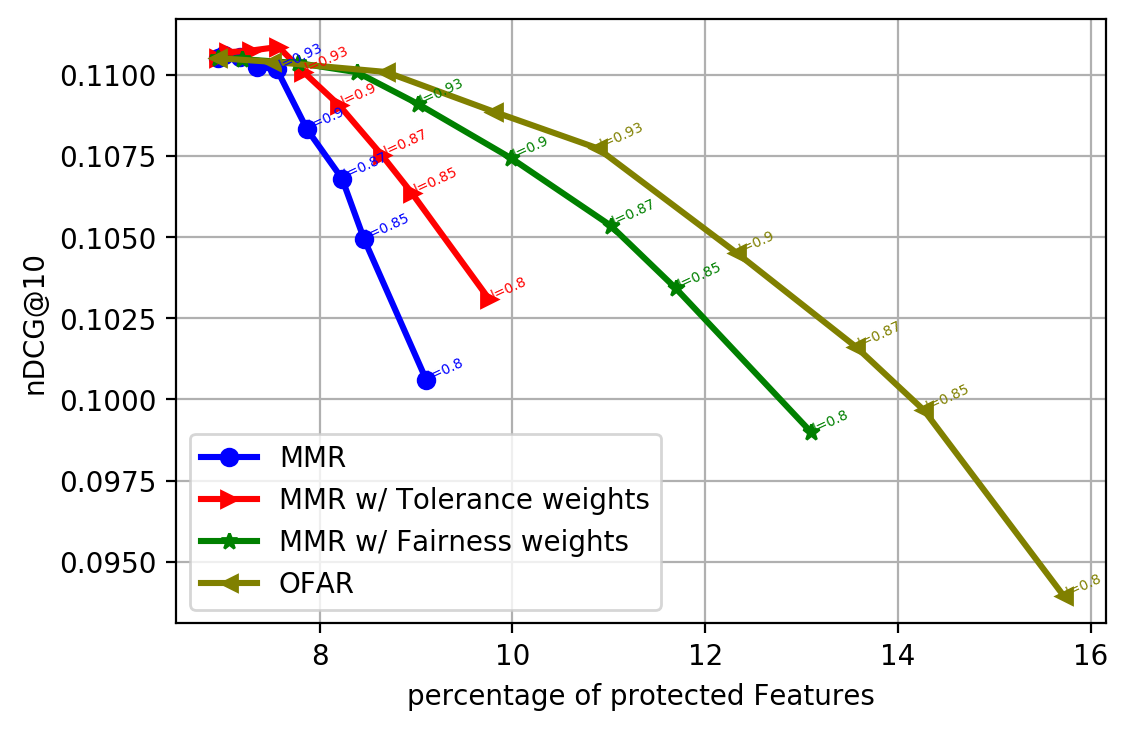

In [116]:


# #---content-based MMR---
# mmr_ndcg = [0.054444250124507786, 0.06924104894885269, 0.08526717935822817, 0.08913726297906006, 0.09298531644574065, 0.09693096002219631, 0.1005854422152475, 0.10492389807551489, 0.1067999793433344, 0.10831541647349893, 0.11016451019545336, 0.11024008132706493, 0.11055082901970463, 0.11059180400543796, 0.11050448469611818]
# mmr_cov = [12.173085337488773, 11.58920626360292, 10.7553919030956, 10.517522046509448, 10.150362694706185, 9.689350567589369, 9.107527945395193, 8.461069517438132, 8.230752014324082, 7.867674539163562, 7.553365510834663, 7.3531319946799885, 7.169640785118416, 7.010928403635992, 6.946921478475711]
# mmr_ild = [1.2784241783331116, 1.2490653760392585, 1.1841577678059032, 1.1581659435291576, 1.1234551929040801, 1.0787935724140576, 1.0192466747714983, 0.938736056062011, 0.9003333439200236, 0.8393746788183981, 0.7823604231314508, 0.7502693522706404, 0.7193181423642326, 0.6928593018430887, 0.6806095989664653]

# #--- MMR + tolerance weights---
# mmr_ent_ndcg = [0.060742372271454154, 0.07597874341625363, 0.08911937253809003, 0.09185414454596834, 0.09562822322918191, 0.099413478892813, 0.10309078425709794, 0.10634269244744128, 0.10751269151865321, 0.10904954054093972, 0.11008638527146378, 0.110853103582662, 0.11073859834528689, 0.11068893996036805, 0.11050448469611818]
# mmr_ent_cov = [13.90113622205163, 13.048242533224691, 11.75276228159053, 11.331032575365857, 10.863536540403636, 10.350265437721449, 9.756283687715381, 8.958126948075483, 8.646158562657824, 8.203155028503687, 7.829044289233492, 7.570554343934116, 7.284533214779526, 7.050611390832406, 6.946921478475711]
# mmr_ent_ild = [1.206618999442943, 1.1719243089683655, 1.1070343858036875, 1.0810890392385295, 1.0486874131138488, 1.004927935436556, 0.9512641616077605, 0.8846192832835017, 0.8559017127407993, 0.8133422959389794, 0.7722348557855656, 0.7448910555157685, 0.7184766489696188, 0.6930017245581002, 0.6806095989664653]

# #--- MMR + Fairness weights---
# mmr_f_ndcg = [0.05302813702276024, 0.06560190911103683, 0.08047471530260271, 0.08470735213562999, 0.08816499841373872, 0.09374335788618968, 0.09899995728263528, 0.10342065059856809, 0.10535447078254809, 0.10742470184410266, 0.10909011167811317, 0.11007407001015901, 0.11035453482008722, 0.11047439274387755, 0.11050448469611818]
# mmr_f_cov = [19.134528067606887, 18.18882523955804, 16.51894278157289, 15.90451164109125, 15.154460256855259, 14.249256795982218, 13.09727819602189, 11.695023910870786, 11.018312496998607, 9.987287078683329, 9.024228504884519, 8.385017534744772, 7.776225826549768, 7.195702351042751, 6.946921478475711]
# mmr_f_ild = [1.194529882315252, 1.1721788915871802, 1.122152415441765, 1.1008659811724892, 1.0736464927590712, 1.03719547225844, 0.9896165188735564, 0.9234549960991046, 0.8903004920158449, 0.8349747799563912, 0.7757391314514511, 0.74138887996101, 0.7132898267032387, 0.6905803514451321, 0.6806095989664653]

# #---ofar: MMR + Fair + Entropy---
# ofar_ndcg = [0.05579256672193798, 0.06404519551053064, 0.07745329383557044, 0.08152613709719904, 0.08577065692607995, 0.08966298250273216, 0.0939490334817064, 0.0996631797606491, 0.10160580950894267, 0.10449533800281967, 0.10773088857109046, 0.10885734708042814, 0.11008154037223612, 0.11039530824873503, 0.11050448469611818]
# ofar_cov = [21.0136172752349, 20.221558131643185, 18.825388872105105, 18.314900477368447, 17.682044508426028, 16.829011599265527, 15.72225274518511, 14.272182596291014, 13.57028824324376, 12.334071010824868, 10.884484916218705, 9.807720616026067, 8.686496128463345, 7.501404986275931, 6.946921478475711]
# ofar_ild = [1.1347561867903841, 1.112122548764366, 1.07241140898978, 1.055766160462739, 1.0343159487072042, 1.0064351657433162, 0.9701403678668378, 0.9182469563802603, 0.8913150387288827, 0.8421493157369596, 0.7850994232323774, 0.7489811073973308, 0.7177613370002902, 0.6915015508798765, 0.6806095989664653]


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
capLabels = ['l=0.2', 'l=0.4', 'l=0.6', 'l=0.65', 'l=0.7', 'l=0.75', 'l=0.8', 'l=0.85', 'l=0.87', 'l=0.9', 'l=0.93', 'l=0.95',' l=0.97', 'l=0.99', 'l=1.0']
#----------

cutoff = 0
fig,ax = plt.subplots(1)
ax.plot(mmr_cov[cutoff:], mmr_ndcg[cutoff:], 'o-', linewidth=2.2, label='MMR', color='blue')
ax.plot(mmr_ent_cov[cutoff:], mmr_ent_ndcg[cutoff:], '>-', linewidth=2.2, label='MMR w/ Tolerance weights', color='red')
ax.plot(mmr_f_cov[cutoff:], mmr_f_ndcg[cutoff:], '*-', linewidth=2.2, label='MMR w/ Fairness weights', color='green')
ax.plot(ofar_cov[cutoff:], ofar_ndcg[cutoff:], '<-', linewidth=2.2, label='OFAR', color='olive')


fig.set_dpi(200)
ax.grid(True)
ax.set_xlabel('percentage of protected Features')
ax.set_ylabel('nDCG@10')
ax.legend()
for i in range(cutoff, len(capLabels)-4):
    ax.annotate(capLabels[i], (mmr_cov[i], mmr_ndcg[i]),size=5, rotation=25, color='blue')
    ax.annotate(capLabels[i], (mmr_ent_cov[i], mmr_ent_ndcg[i]),size=5, rotation=25, color='red')
    ax.annotate(capLabels[i], (mmr_f_cov[i], mmr_f_ndcg[i]),size=5, rotation=25, color='green')
    ax.annotate(capLabels[i], (ofar_cov[i], ofar_ndcg[i]),size=5, rotation=25, color='olive')
plt.show()

# fig.savefig('./plots/ml_cov_ndcg_relationship_CountryGenre.png', format='png', dpi=300, bbox_inches='tight')

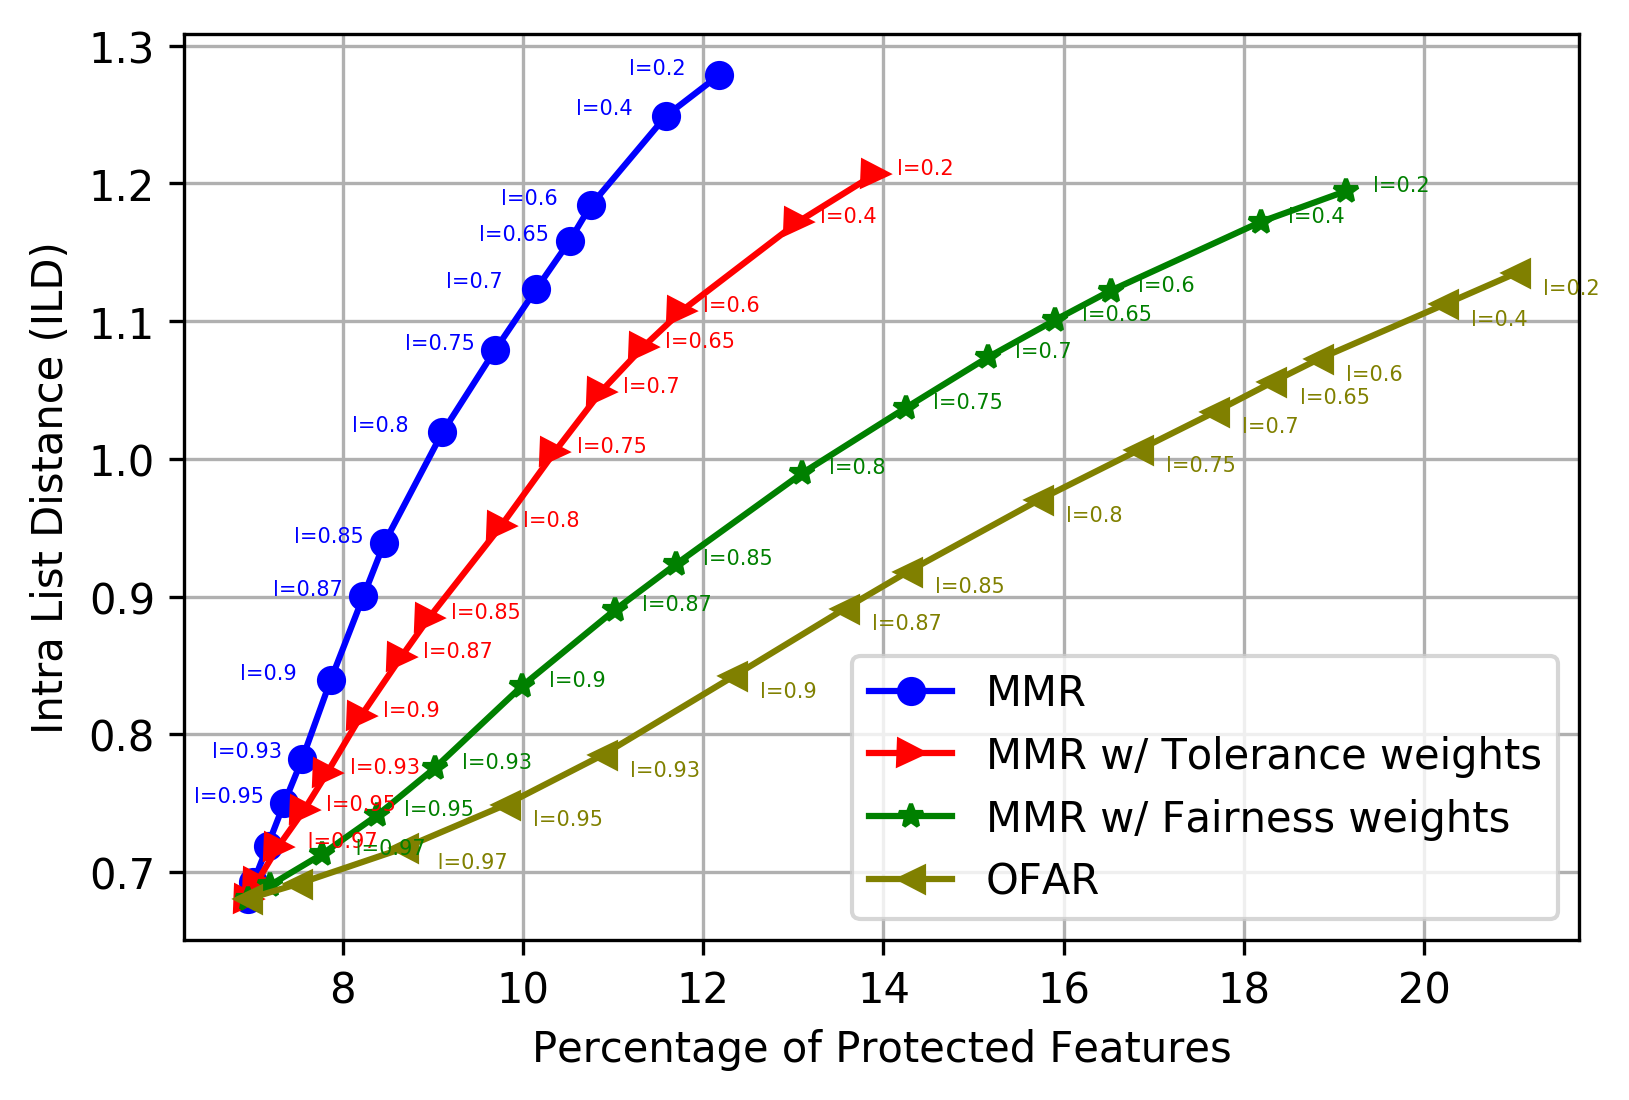

In [221]:
cutoff=0
fig,ax = plt.subplots(1)
ax.plot(mmr_cov[cutoff:], mmr_ild[cutoff:], 'o-', linewidth=1.5, label='MMR', color='blue')
ax.plot(mmr_ent_cov[cutoff:], mmr_ent_ild[cutoff:], '>-', linewidth=1.5, label='MMR w/ Tolerance weights', color='red')
ax.plot(mmr_f_cov[cutoff:], mmr_f_ild[cutoff:], '*-', linewidth=1.5, label='MMR w/ Fairness weights', color='green')
ax.plot(ofar_cov[cutoff:], ofar_ild[cutoff:], '<-', color='olive', linewidth=1.5, label='OFAR')

fig.set_dpi(300)
ax.grid(True)
ax.set_xlabel('Percentage of Protected Features')
ax.set_ylabel('Intra List Distance (ILD)')
ax.legend()
# for i in range(cutoff, len(capLabels[:13])):
#     ax.annotate(capLabels[i], (mmr_cov[i]-0.4, mmr_ild[i]+0.001),size=5, rotation=30, color='blue')
#     ax.annotate(capLabels[i], (mmr_ent_cov[i]+0.1, mmr_ent_ild[i]),size=5,rotation=30, color='red')
#     ax.annotate(capLabels[i], (mmr_f_cov[i]+0.15, mmr_f_ild[i]),size=5, rotation=30, color='green')
#     ax.annotate(capLabels[i], (ofar_cov[i], ofar_ild[i]-0.015),size=5, rotation=30, color='olive')
# plt.show()

for i in range(cutoff, len(capLabels[:13])):
    ax.annotate(capLabels[i], (mmr_cov[i]-1, mmr_ild[i]+0.001),size=5, rotation=0, color='blue')
    ax.annotate(capLabels[i], (mmr_ent_cov[i]+0.25, mmr_ent_ild[i]),size=5,rotation=0, color='red')
    ax.annotate(capLabels[i], (mmr_f_cov[i]+0.3, mmr_f_ild[i]),size=5, rotation=0, color='green')
    ax.annotate(capLabels[i], (ofar_cov[i]+0.3, ofar_ild[i]-0.015),size=5, rotation=0, color='olive')
plt.show()
fig.savefig('./plots/ml_ild_perc_protected_relationship_CountryGenre.png', format='png', dpi=300, bbox_inches='tight')

In [85]:
lam=0.2

# -------------------------------------------------------------------------------------------------------------------------------

filename = './ml_results/rec_MMR_lam%s.csv'%lam
mmr_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])

filename = './ml_results/rec_tol_MMR_lam%s.csv'%lam
ent_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])

filename = './ml_results/rec_tol_fair_MMR_lam%s_Genre&Country.csv'%lam
fair_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])

filename = './ml_results/rec_MMR_fair_lam%s_Genre&Country.csv'%lam
f_rr_recs = pd.read_csv(filename, header=None, names=['userid', 'itemid', 'rating'])

# -------------------------------------------------------------------------------------------------------------------------------

nmf_items = list(map(int,nmf_at10_df['itemid'].tolist()))
print('# nmf unique items',len(set(nmf_items)),len(nmf_items))

mmr_items = list(map(int,mmr_rr_recs['itemid'].tolist()))
print('# mmr  unique items',len(set(mmr_items)), len(mmr_items))

ent_items = list(map(int,ent_rr_recs['itemid'].tolist()))
print('# ent  unique items',len(set(ent_items)), len(ent_items))

fair_items = list(map(int,fair_rr_recs['itemid'].tolist()))
print('# fair  unique items',len(set(fair_items)), len(fair_items))

f_items = list(map(int, f_rr_recs['itemid'].tolist()))
print('# f  unique items', len(set(f_items)), len(f_items))

# nmf unique items 728 60000
# mmr  unique items 944 60000
# ent  unique items 1136 60000
# fair  unique items 976 60000
# f  unique items 838 60000


In [153]:
a = item_features_df.loc[nmf_items].sum(axis=0) / item_features_df.loc[nmf_items].sum(axis=0).sum() * 100
b = item_features_df.loc[mmr_items].sum(axis=0) / item_features_df.loc[mmr_items].sum(axis=0).sum() * 100
c = item_features_df.loc[ent_items].sum(axis=0) / item_features_df.loc[ent_items].sum(axis=0).sum() * 100
d = item_features_df.loc[f_items].sum(axis=0) / item_features_df.loc[f_items].sum(axis=0).sum() * 100
e = item_features_df.loc[fair_items].sum(axis=0) / item_features_df.loc[fair_items].sum(axis=0).sum() * 100

# select the protected attributes
df = pd.concat([a[pro],b[pro],c[pro],d[pro],e[pro]], axis=1)
df.columns = ['NMF', 'MMR', 'MMR + ent ws', 'MMR + fair ws', 'MMR + ent & fair ws']
df

,NMF,MMR,MMR + ent ws,MMR + fair ws,MMR + ent & fair ws
CA,0.178857,0.511076,0.447465,0.938137,0.737608
DE,0.328921,1.168128,1.024360,1.361379,1.205922
ES,0.008638,0.550684,0.545984,0.729299,0.689613
HK,0.108568,0.567454,0.360187,0.744356,0.661603
Horror,0.335527,0.425311,0.783519,1.167107,1.542539
Music,0.220523,0.545574,0.598053,1.298368,1.555316
History,0.608894,0.532956,0.837902,0.806877,1.379391
Mystery,1.086524,0.764218,1.119738,1.403605,1.686850


In [185]:
p_country_row = df.iloc[:4, :].sum(axis=0)
p_genre_row = df.iloc[4:, :].sum(axis=0)
tbl = pd.concat([pd.DataFrame(p_country_row), pd.DataFrame(p_genre_row)],axis=1,ignore_index=True).T
tbl.rename(index={0:'pro countries', 1:'pro genres'})

,NMF,MMR,MMR + ent ws,MMR + fair ws,MMR + ent & fair ws
pro countries,0.624984,2.797342,2.377997,3.773171,3.294747
pro genres,2.251467,2.268059,3.339212,4.675956,6.164095


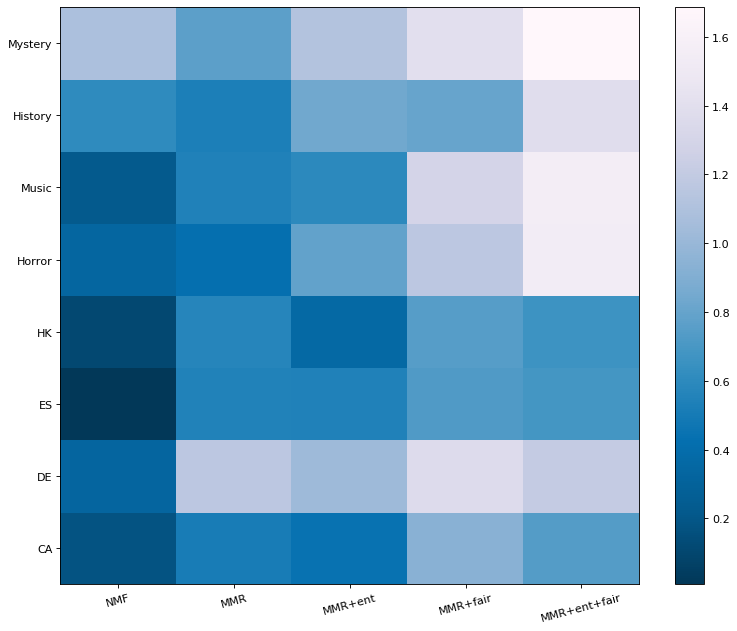

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

cmaplist=['PuBu_r','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
cmaplist2 = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink', 'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper']


plt.pcolor(df,cmap='PuBu_r')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=15)
plt.colorbar()
# plt.show()
plt.tight_layout()
plt.savefig('./plots/heatmap_ml_lambda0.2_CountryGenre.png',dpi=100)

In [88]:
bl = df.loc[df.index[:4].tolist()].sum().tolist()
rd = df.loc[df.index[4:].tolist()].sum().tolist()

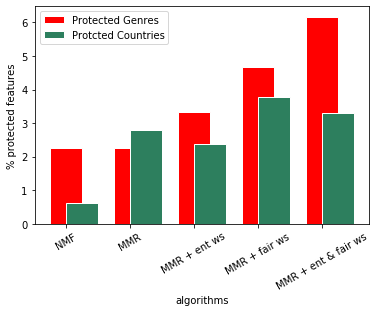

In [222]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import rc
import pandas as pd
 
# y-axis in bold
# rc('font', weight='bold')
 
bars = np.add(bl, rd).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4]
 
# Names of group and bar width
names = df.columns.tolist()
barWidth = 0.5

plt.bar(r, rd, color='red', edgecolor='white', width=barWidth, label='Protected Genres')    
plt.bar(np.array(r)+0.25, bl, color='#2d7f5e', edgecolor='white', width=barWidth, label='Protcted Countries')

    
# Custom X axis
plt.xticks(r, names, rotation=30)
plt.xlabel("algorithms")
plt.ylabel("% protected features")
plt.legend()
 
# Show graphic
# plt.show()
plt.savefig('./plots/barplot_ml_lambda0.2_CountryGenre.png',dpi=100, bbox_inches='tight')